<a href="https://colab.research.google.com/github/2303a51019/NLP/blob/main/NLP_LAB_O6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# --- 1. Load and Prepare Data ---
# Load the dataset. We only use a few categories for faster processing.
print("Loading dataset...")
categories = ['sci.med', 'sci.space', 'comp.graphics', 'talk.politics.mideast']
newsgroups_data = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

Loading dataset...


In [3]:
# Split data into training and testing sets for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    newsgroups_data.data, newsgroups_data.target, test_size=0.25, random_state=42
)

In [4]:
print(f"Data loaded. Training set size: {len(X_train)}, Test set size: {len(X_test)}")
print("-" * 50)

Data loaded. Training set size: 2917, Test set size: 973
--------------------------------------------------


In [5]:
# --- 2. Define Models and Parameters to Test ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1) # Use all available cores
}
# TF-IDF vectorizer parameters
max_features_options = [5000, 10000, 20000]

In [7]:
# --- 3. Run Experiments ---
results = []
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

for max_f in max_features_options:
    print(f"Running experiments for max_features = {max_f}...")

    # Create TF-IDF features
    vectorizer = TfidfVectorizer(max_features=max_f, stop_words='english')
    X_train_tfidf = vectorizer.fit_transform(X_train)

    for model_name, model in models.items():
        print(f"  Training {model_name}...")

        # Perform 5-fold cross-validation
        cv_results = cross_validate(
            estimator=model,
            X=X_train_tfidf,
            y=y_train,
            cv=5,
            scoring=scoring_metrics,
            return_train_score=False # We don't need train scores for this analysis
        )

        # Store the average results
        results.append({
            "Model": model_name,
            "Max Features": max_f,
            "Avg Fit Time (s)": np.mean(cv_results['fit_time']),
            "Avg Accuracy": np.mean(cv_results['test_accuracy']),
            "Avg F1-score": np.mean(cv_results['test_f1_macro'])
        })
        print(f"    Done. Avg F1-score: {np.mean(cv_results['test_f1_macro']):.4f}")

print("-" * 50)


Running experiments for max_features = 5000...
  Training Logistic Regression...
    Done. Avg F1-score: 0.9687
  Training Naive Bayes...
    Done. Avg F1-score: 0.9649
  Training Random Forest...
    Done. Avg F1-score: 0.9346
Running experiments for max_features = 10000...
  Training Logistic Regression...
    Done. Avg F1-score: 0.9717
  Training Naive Bayes...
    Done. Avg F1-score: 0.9690
  Training Random Forest...
    Done. Avg F1-score: 0.9380
Running experiments for max_features = 20000...
  Training Logistic Regression...
    Done. Avg F1-score: 0.9704
  Training Naive Bayes...
    Done. Avg F1-score: 0.9737
  Training Random Forest...
    Done. Avg F1-score: 0.9418
--------------------------------------------------


In [8]:
# --- 4. Analyze Results ---
# Create a DataFrame for easy comparison
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="Avg F1-score", ascending=False).reset_index(drop=True)

print("Model Performance Comparison Table:")
print(results_df_sorted)
print("-" * 50)

# Find the best performing model configuration
best_result = results_df_sorted.iloc[0]
best_model_name = best_result['Model']
best_max_features = int(best_result['Max Features'])

print(f"🏆 Best Performing Model: {best_model_name}")
print(f"   - Optimal Max Features: {best_max_features}")
print(f"   - Cross-validated F1-score: {best_result['Avg F1-score']:.4f}")
print("-" * 50)


Model Performance Comparison Table:
                 Model  Max Features  Avg Fit Time (s)  Avg Accuracy  \
0          Naive Bayes         20000          0.010905      0.973605   
1  Logistic Regression         10000          1.298473      0.971547   
2  Logistic Regression         20000          1.268556      0.970176   
3          Naive Bayes         10000          0.010372      0.968804   
4  Logistic Regression          5000          0.708973      0.968461   
5          Naive Bayes          5000          0.009822      0.964691   
6        Random Forest         20000          2.955244      0.941037   
7        Random Forest         10000          2.387538      0.937270   
8        Random Forest          5000          2.365576      0.933839   

   Avg F1-score  
0      0.973700  
1      0.971746  
2      0.970423  
3      0.968974  
4      0.968657  
5      0.964887  
6      0.941776  
7      0.937957  
8      0.934638  
--------------------------------------------------
🏆 Best Perfo

Evaluating the best model on the held-out test set...
Final Test Set Accuracy: 0.9712


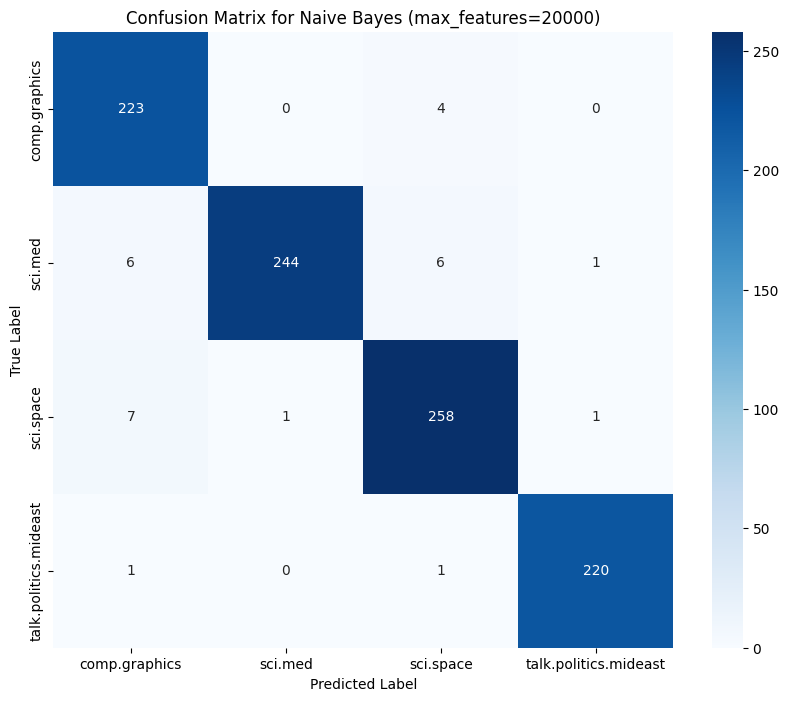

In [9]:

# --- 5. Evaluate Best Model on Test Set & Plot Confusion Matrix ---
print("Evaluating the best model on the held-out test set...")

# Re-train the vectorizer and the best model on the FULL training data
final_vectorizer = TfidfVectorizer(max_features=best_max_features, stop_words='english')
X_train_final = final_vectorizer.fit_transform(X_train)
X_test_final = final_vectorizer.transform(X_test)

final_model = models[best_model_name]
final_model.fit(X_train_final, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test_final)
final_accuracy = accuracy_score(y_test, y_pred)

print(f"Final Test Set Accuracy: {final_accuracy:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=newsgroups_data.target_names,
    yticklabels=newsgroups_data.target_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {best_model_name} (max_features={best_max_features})')
plt.show()


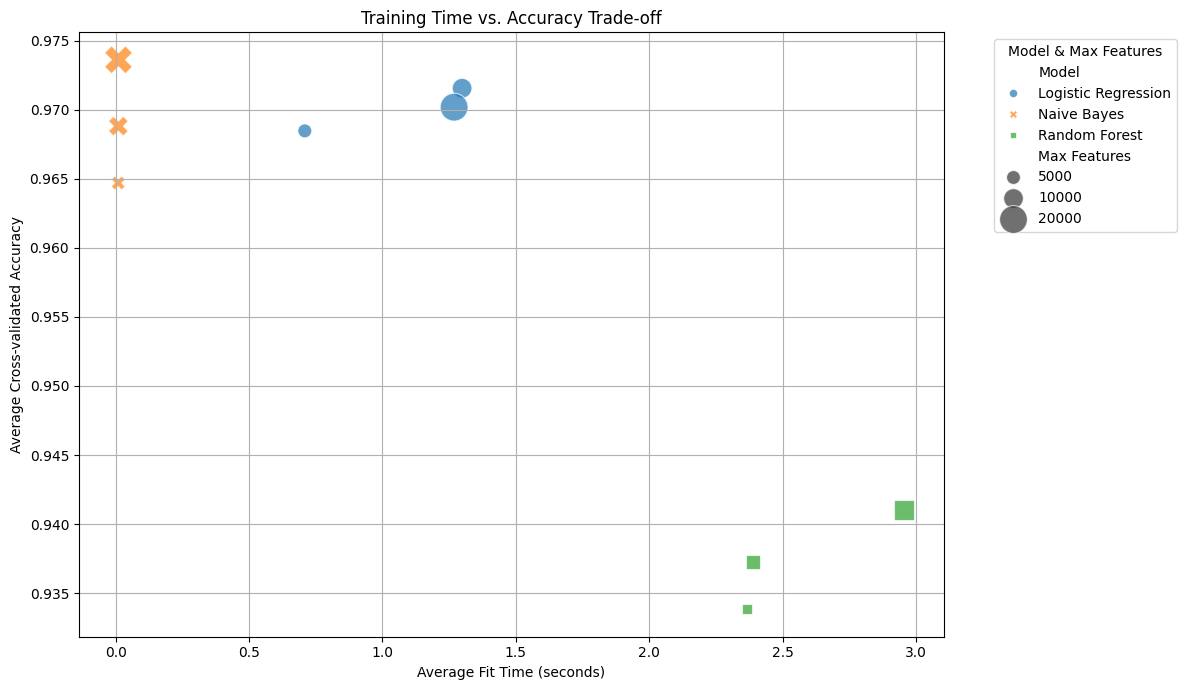

In [10]:
# --- 6. Plot Training Time vs. Accuracy Trade-off ---
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=results_df,
    x="Avg Fit Time (s)",
    y="Avg Accuracy",
    hue="Model",
    size="Max Features",
    sizes=(100, 400),
    alpha=0.7,
    style="Model"
)
plt.title("Training Time vs. Accuracy Trade-off")
plt.xlabel("Average Fit Time (seconds)")
plt.ylabel("Average Cross-validated Accuracy")
plt.grid(True)
plt.legend(title="Model & Max Features", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()